In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView
from networkx.drawing.nx_agraph import graphviz_layout

from ic import simulate_cascade, observe_cascade, get_gvs, get_o2src_time, get_infection_time, gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.2

gvs = get_gvs(g, p, N2)
pos = graphviz_layout(gnx, root=0)

In [2]:
infection_times, source, obs_nodes = gen_nontrivial_cascade(g, p, q)

<IPython.core.display.Javascript object>


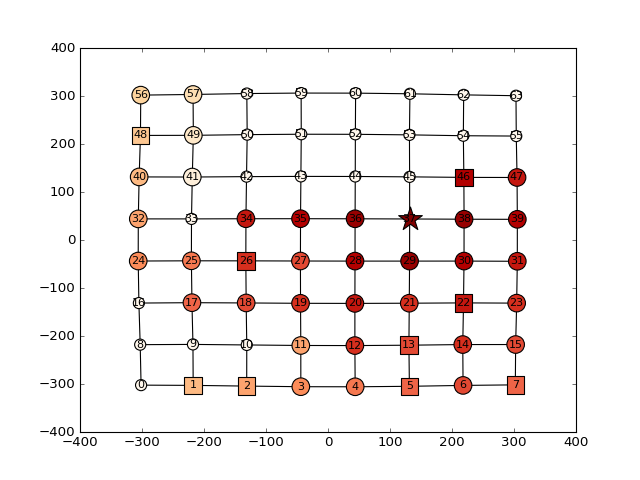

In [3]:
from plot_utils import plot_snapshot
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True)

In [4]:
def all_simple_paths_of_length(g, source, target, length, 
                               forbidden_nodes=set(),
                               debug=False):
    if length < 1:
        return
    
    visited = [source]
    stack = [g.vertex(source).all_neighbours()]
    while stack:
        children = stack[-1]
        child = next(children, None)
        if debug:
            print('child: {}'.format(child))
        if child is None:
            if debug:
                print('no more child')
            stack.pop()
            visited.pop()
        elif child in forbidden_nodes:
            if debug:
                print('got forbidden node {}'.format(child))
            pass
        elif len(visited) == length:
            if debug:
                print('correct length {}'.format(len(visited)))
                print('child ({}) = target ({})? {}'.format(child, target, child == target))
            if child == target:
                if debug:
                    print('found target')
                yield visited + [target]
                stack.pop()
                visited.pop()
        elif len(visited) > length:
            stack.pop()
            visited.pop()
        else: # still more edges to go
            if debug:
                print('len(visited) length {}'.format(len(visited)))
            if child not in visited:
                visited.append(int(child))
                stack.append(g.vertex(child).all_neighbours())

In [75]:
target = 13
length = 14
cand_source = 0
forbidden_nodes = [o for o in obs_nodes
                   if infection_times[o] >= infection_times[target] and o != target]    
for p in all_simple_paths_of_length(g, source, target,
                                    length=length, 
                                    forbidden_nodes=forbidden_nodes,
                                    debug=False):
    print(p)
    assert len(p) - 1 == length, '{} != {}'.format(len(p)-1, length)
    for u, v in zip(p[:-1], p[1:]):
        assert g.edge(u, v) is not None
    for u in p:
        assert u not in forbidden_nodes
    assert p[0] == source
    assert p[-1] == target
    
    break

In [88]:
def sample_consistent_cascade(g, obs_nodes, cand_source, infection_times, debug=False):
    save_all_paths = False
    all_paths = []
    tree_paths = []
    t_min = min(infection_times[obs_nodes])
    earliest_node = min(obs_nodes, key=infection_times.__getitem__)
    if debug:
        print('candidate {}'.format(cand_source))
        print('earliest node: {} (t={})'.format(earliest_node, t_min))

    # maximum infection time of source assuming cand_source is source
    # consider only latest infection time
    # can be generalized to other times
    ts_max = t_min - shortest_distance(g, source=cand_source, target=earliest_node)
    
    if debug:
        print('observed infection times {}'.format({o: infection_times[o] for o in obs_nodes}))
        print('max(t_s) = {}'.format(ts_max))
    obs_nodes_done = []
    for o in sorted(obs_nodes, key=infection_times.__getitem__):
        for obs_nodes_done
        length = infection_times[target] - ts_max
        if debug:
            print('target={}'.format(target))
            print('length({}, {})={}'.format(target, cand_source, length))
            
        forbidden_nodes = {o for o in obs_nodes
                           if infection_times[o] >= infection_times[target] and o != target}
        paths = all_simple_paths_of_length(g, cand_source, target,
                                           length=length, 
                                           forbidden_nodes=forbidden_nodes,
                                           debug=False)        
        try:
            path = next(paths)
            tree_paths.append(path)
            assert len(path) - 1 == length, "{} != {}".format(len(path) - 1, length)
            assert ts_max + length == infection_times[target], "{} != {}".format(ts_max + length, infection_times[target])
        except StopIteration:
            return None
        obs_nodes_done.append(target)
        
    edges = set([(u, v) for p in tree_paths for u, v in zip(p[:-1], p[1:])])
    efilt = np.array([(((int(u), int(v)) in edges) or ((int(v), int(u)) in edges))
                  for u, v in g.edges()],
                 dtype=bool)
    gv = GraphView(g, efilt=efilt)
    pred_inf_time = get_infection_time(gv, cand_source)
    pred_inf_time += ts_max
    if debug:
        print(obs_nodes)
    assert_array_equal(pred_inf_time[obs_nodes], infection_times[obs_nodes])    
    return gv

In [89]:
_ = sample_consistent_cascade(g, obs_nodes, source, infection_times, debug=True)

candidate 37
earliest node: 46 (t=2)
observed infection times {48: 11, 1: 10, 2: 9, 5: 6, 22: 3, 7: 6, 26: 4, 13: 5, 46: 2}
max(t_s) = 0
target=46
length(46, 37)=2
target=22
length(22, 37)=3
target=26
length(26, 37)=4
target=13
length(13, 37)=5
target=7
length(7, 37)=6
target=5
length(5, 37)=6
target=2
length(2, 37)=9
target=1
length(1, 37)=10
target=48
length(48, 37)=11
[13  1  7 48  5  2 46 26 22]


AssertionError: 
Arrays are not equal

(mismatch 22.22222222222223%)
 x: PropertyArray([ 5,  8,  6, 11,  6,  7,  2,  4,  3], dtype=int32)
 y: PropertyArray([ 5, 10,  6, 11,  6,  9,  2,  4,  3], dtype=int32)

In [77]:
from numpy.testing import assert_array_equal
remaining_nodes = set(np.arange(g.num_vertices())) - set(obs_nodes)
cs2gv = {}
for cand_source in tqdm(remaining_nodes):
    gv = sample_consistent_cascade(g, obs_nodes, cand_source, infection_times, debug=True)
    if gv is not None:
        cs2gv[cand_source] = gv

  0%|          | 0/55 [00:00<?, ?it/s]

candidate 0
earliest node: 46 (t=2)
observed infection times {48: 11, 1: 10, 2: 9, 5: 6, 22: 3, 7: 6, 26: 4, 13: 5, 46: 2}
max(t_s) = -9
target=46
length(46, 0)=11
target=22
length(22, 0)=12
target=26
length(26, 0)=13
target=13
length(13, 0)=14
target=7
length(7, 0)=15
target=5
length(5, 0)=15
target=2
length(2, 0)=18
target=1
length(1, 0)=19
target=48
length(48, 0)=20
-9
[3 6 6 3 4 5 2 4 3]


AssertionError: 
Arrays are not equal

(mismatch 55.55555555555556%)
 x: PropertyArray([3, 6, 6, 3, 4, 5, 2, 4, 3], dtype=int32)
 y: PropertyArray([ 5, 10,  6, 11,  6,  9,  2,  4,  3], dtype=int32)

In [80]:
ts_max = 0
cand_source = 37
target = 48
length = infection_times[target] - ts_max
forbidden_nodes = [o for o in obs_nodes
                   if infection_times[o] >= infection_times[target] and o != target]    
paths = all_simple_paths_of_length(g, cand_source, target,
                                   length=length, 
                                   forbidden_nodes=forbidden_nodes,
                                   debug=False)        
print(len(next(paths)))
print(infection_times[target])

12
11


In [20]:
def extract_edges(gt_edges):
    return [(int(u), int(v)) for u, v in gt_edges]

<IPython.core.display.Javascript object>


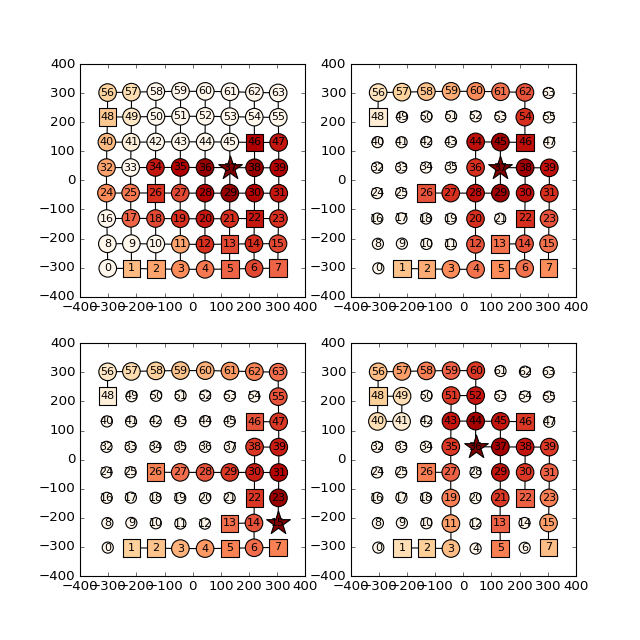

[37, 45, 46, 54, 62, 61, 60, 59, 58, 57, 56, 48]

In [29]:
import random
pool = [n for n in list(remaining_nodes - {source}) if n in cs2gv]
random.shuffle(pool)
n1, n2 = pool[:2]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True, ax=ax[0, 0])
plot_snapshot(gnx, pos, get_infection_time(cs2gv[source], source), queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(cs2gv[source].edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[n1], n1), queried_nodes=obs_nodes, source_node=n1, with_labels=True, ax=ax[1, 0],
              edges=extract_edges(cs2gv[n1].edges()))
plot_snapshot(gnx, pos, get_infection_time(cs2gv[n2], n2), queried_nodes=obs_nodes, source_node=n2, with_labels=True, ax=ax[1, 1],
              edges=extract_edges(cs2gv[n2].edges()))
[37, 45, 46, 54, 62, 61, 60, 59, 58, 57, 56, 48]

In [38]:
sample_consistent_cascade(g, obs_nodes, 15, infection_times, debug=True)

earliest node: 46 (t=2)
observed infection times {48: 11, 1: 10, 2: 9, 5: 6, 22: 3, 7: 6, 26: 4, 13: 5, 46: 2}
max(t_s) = -3
target=46
length(46, 15)=5
target=22
length(22, 15)=6
target=26
length(26, 15)=7
target=13
length(13, 15)=8
target=7
length(7, 15)=9
target=5
length(5, 15)=9
target=2
length(2, 15)=12
target=1
length(1, 15)=13
target=48
length(48, 15)=14


{(2, 1),
 (3, 2),
 (4, 3),
 (5, 4),
 (6, 5),
 (6, 7),
 (14, 6),
 (14, 13),
 (15, 23),
 (22, 14),
 (23, 31),
 (27, 26),
 (28, 27),
 (29, 28),
 (30, 22),
 (30, 29),
 (31, 30),
 (31, 39),
 (38, 30),
 (39, 38),
 (39, 47),
 (47, 46),
 (47, 55),
 (55, 63),
 (56, 48),
 (57, 56),
 (58, 57),
 (59, 58),
 (60, 59),
 (61, 60),
 (62, 61),
 (63, 62)}

In [37]:

print(get_infection_time(cs2gv[15], source=15)[[46, 47]])
print(infection_times[[46, 47]])

[5 4]
[2 3]
